# **JL**

## **NLP Project: SMS Spam Detection 📝**

### **1. Libraries/Dependencies**

In [1]:
%reset -f
# General
import numpy as np
import pandas as pd
import random
import re
import os
import pickle

# EDA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, Latex, HTML, Markdown
import scikitplot as skplt

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import string

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import tree

%matplotlib inline

In [2]:
# Setting seed for reproducibility
seed_value = np.uint64(107)
print("Using seeds: ",seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)

Using seeds:  107


In [3]:
# Requirements for NLTK
# nltk.download('punkt')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

### **2. Dataset**

In [4]:
# Initializing dataset of spam and ham messages
data = pd.read_csv(r'../SMS_spam_detection/Datasets/spam.csv', encoding="latin-1")

data.dropna(how="any", inplace=True, axis=1)
data.columns = ['Label', 'Message']
data.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
display(Markdown("<br>***The shape of the dataset is:***"))
display(data.shape)
display(data.head(n = 10))

display(Markdown("<br>***Summary of dataset including descriptive statistics and data type***"))
display(data.info())
display(data.describe().T)

<br>***The shape of the dataset is:***

(5572, 2)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


<br>***Summary of dataset including descriptive statistics and data type***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


None

,count,unique,top,freq
Label,5572,2,ham,4825
Message,5572,5169,"Sorry, I'll call later",30


There are a total of 5572 SMS in this dataset with 2 column labels and messages.

### **3. Exploratory Data Analysis**


Now we are going to take a look at the label distribution and the message length.

In [6]:
data.groupby('Label').describe().T

Label                              ham  \
Message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

Label                                                        spam  
Message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In the groupby function above, labels can be described in which the features are separated between ham and spam.
- Out of 4825 ham messages, 4516 of them are unique.
- Out of 747 spam messages, 653 of them are unique.
- "Sorry, I'll call later" is the highest ham message sent over 30 times.
- "Please call our customer service representativ..." is the highest spam message sent over 4 times. 

In [7]:
data['Char_No'] = data['Message'].apply(len)
data.sample(5)

,Label,Message,Char_No
3571,ham,"Yup, leaving right now, be back soon",36
5372,ham,"Ok., is any problem to u frm him? Wats matter?",46
2158,ham,I think you should go the honesty road. Call t...,114
567,ham,"So anyways, you can just go to your gym or wha...",142
3054,spam,EASTENDERS TV Quiz. What FLOWER does DOT compa...,153


Check if there are any null values in the dataset

In [8]:
display(Markdown("<br>***Summary of existing null values in the dataset***"))
display(data.isnull().sum())

<br>***Summary of existing null values in the dataset***

Label      0
Message    0
Char_No    0
dtype: int64

#### **3.1 Data Visualization**

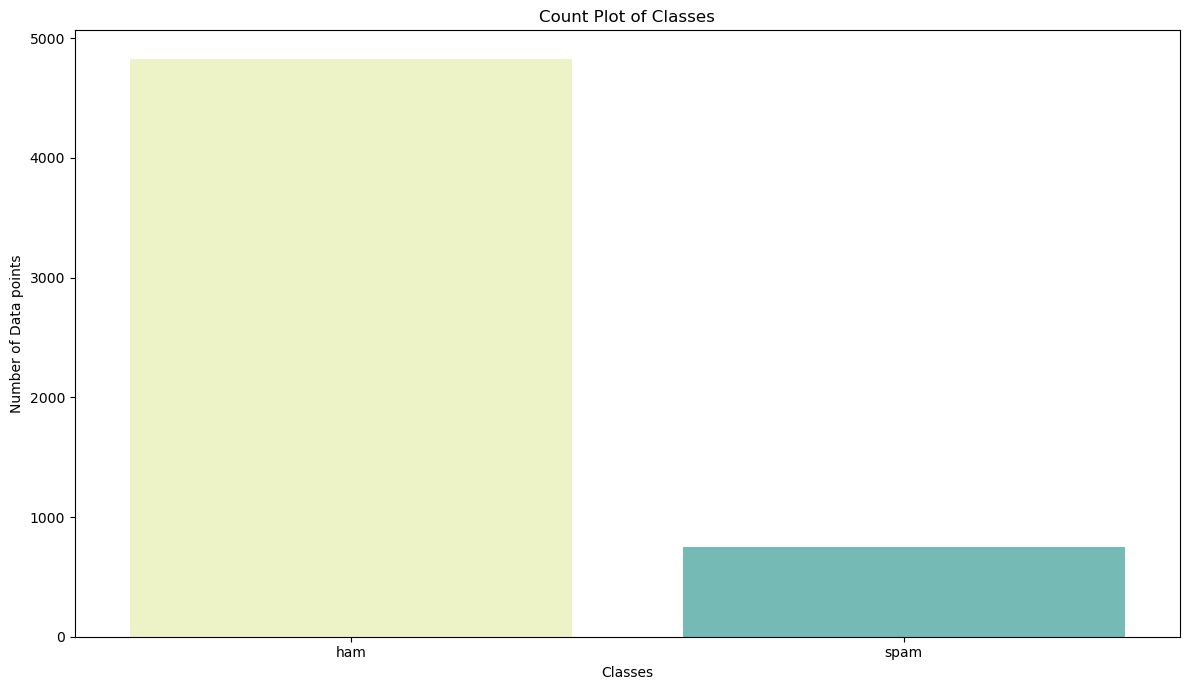

In [9]:
# Palette
col = ["#f3fabe", "#6ac5bd"]
# Evaluate the labels and find out if there is imbalance in dataset. 
plt.figure(figsize=(12,7))
fg = sns.countplot(x= data['Label'], palette= col)
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")
plt.tight_layout()
plt.show()

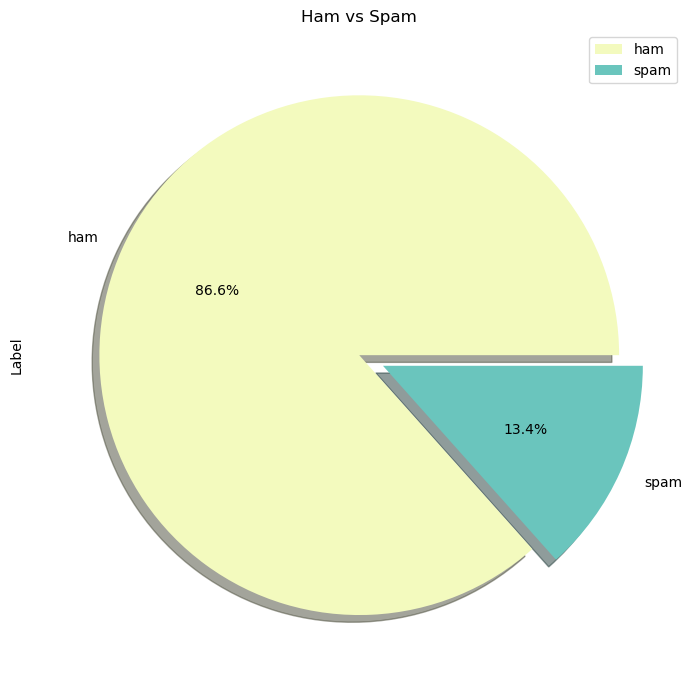

In [10]:
data['Label'].value_counts().plot(kind='pie', explode=[0, 0.1], figsize=(12,7), autopct='%1.1f%%', shadow=True, colors=col)
plt.title("Ham vs Spam")
plt.legend(["ham", "spam"])
plt.tight_layout()
plt.show()

It is evident from the 2 graphs above that there is an imbalance in the dataset, 
about 86% of the dataset are not actually spam and consists of normal messages.

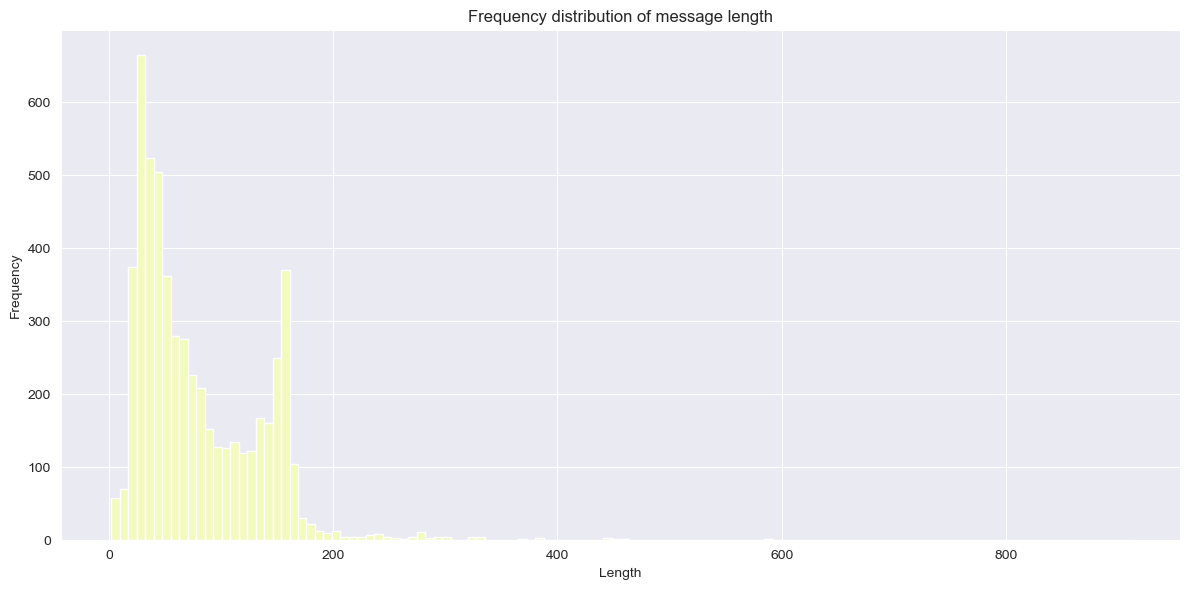

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
data['Char_No'].plot(bins=120, kind='hist', color=col) # 120 length bins (120 length intervals)
plt.title("Frequency distribution of message length")
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

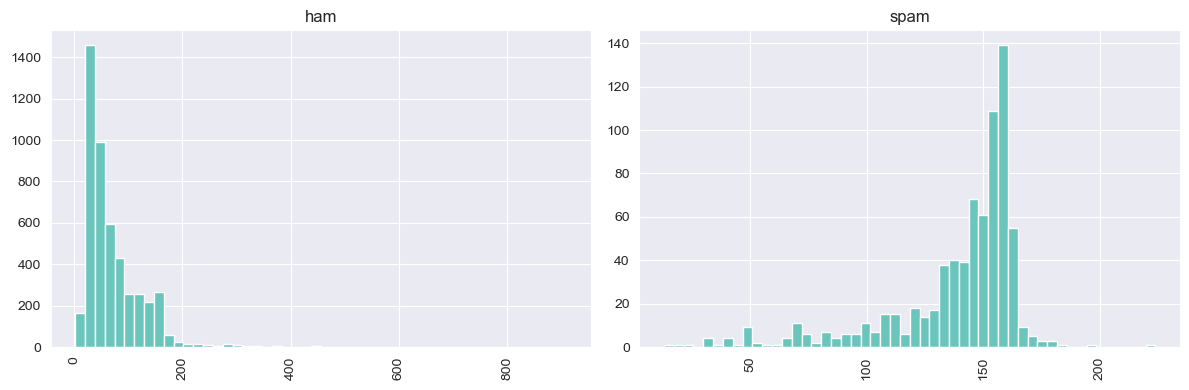

In [12]:
# Separating the frequency distribution graph into 2 classes
data.hist(column='Char_No', by='Label', bins=50, figsize=(12,4), color=col[1])
plt.tight_layout()
plt.show()

From the frequency distribution above, messages that occurred more are less than 200 length. Notice that the length x-axis go all the way to 800, so there might be some messages that are quite long. We are able to observe the trend that spam messages has more characters compared to ham messages. 

To explore the data more, new features needs to be created

In [13]:
# Adding a column of numbers of words and sentences in each msg
data["Words_No"] = data["Message"].apply(lambda x: len(nltk.word_tokenize(x))) #data["Words_No"]=data.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)
data["Sentences_No"]= data["Message"].apply(lambda x: len(nltk.sent_tokenize(x))) #data["Sentences_No"]=data.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

# Characters, words, and sentences are tokenized using same length. 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Char_No,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
Words_No,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
Sentences_No,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


In [14]:
# convert label to a numerical variable
encoder = LabelEncoder()
data['Label'] = encoder.fit_transform(data['Label'])
display(Markdown("<br>***Encoded labels***"))
display(data.head())

# Ham messages summary 
display(Markdown("<br>***Descriptive statistics of Ham messages***"))
display(data.loc[data['Label'] == 0, ['Char_No', 'Words_No', 'Sentences_No']].describe().T)
# Spam messages summary 
display(Markdown("<br>***Descriptive statistics of Spam messages***"))
display(data.loc[data['Label'] == 1, ['Char_No', 'Words_No', 'Sentences_No']].describe().T)

<br>***Encoded labels***

,Label,Message,Char_No,Words_No,Sentences_No
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


<br>***Descriptive statistics of Ham messages***

,count,mean,std,min,25%,50%,75%,max
Char_No,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
Words_No,4825.0,17.271917,13.988885,1.0,8.0,13.0,22.0,220.0
Sentences_No,4825.0,1.808705,1.328227,1.0,1.0,1.0,2.0,28.0


<br>***Descriptive statistics of Spam messages***

,count,mean,std,min,25%,50%,75%,max
Char_No,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0
Words_No,747.0,27.891566,6.867007,2.0,25.0,29.0,32.0,46.0
Sentences_No,747.0,3.017403,1.528449,1.0,2.0,3.0,4.0,8.0


From the descriptive statistics of both ham and spam messages, it can be seen that the number of characters in a spam message is higher than non-spam messages and the same can also be said for the words and sentences. 

<Figure size 1200x600 with 0 Axes>

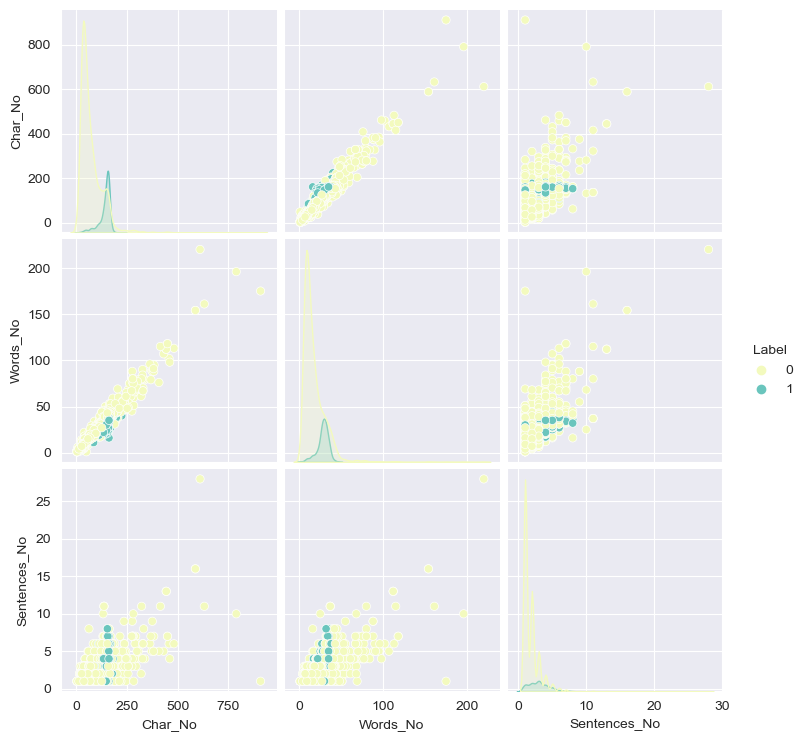

In [15]:
plt.figure(figsize=(12,6))
fig = sns.pairplot(data=data, hue='Label', palette=col)
plt.show(fig)

From the pair plot above, there are multiple outliers found in the Ham label. Note that label 0 is classified as ham messages whereas label 1 is classified as spam messages. Knowing that we have these outliers, we can just drop it. 

(5555, 5)

<Figure size 1200x600 with 0 Axes>

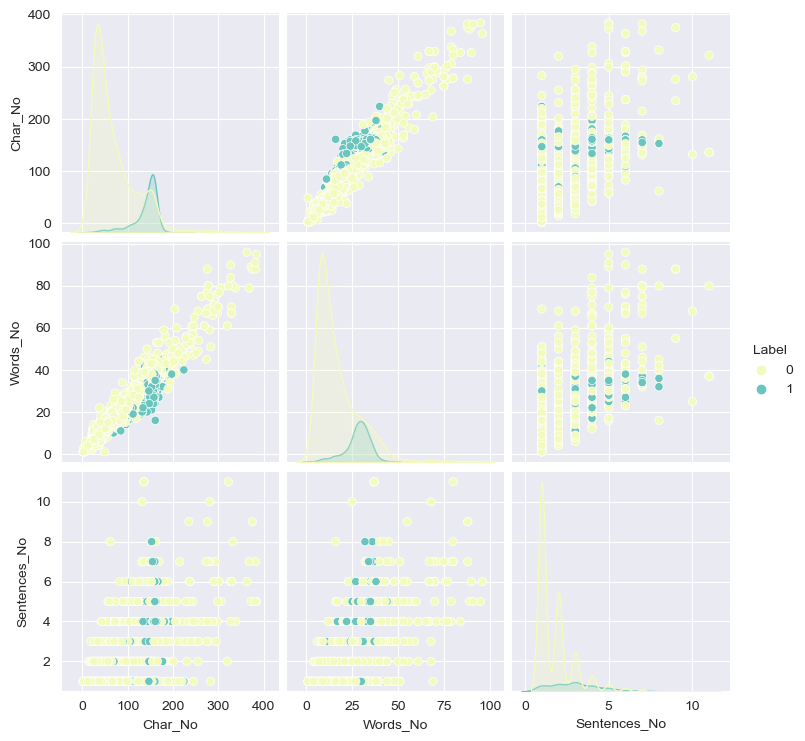

In [16]:
data = data[(data['Char_No'] < 400)]
display(data.shape)

plt.figure(figsize=(12,6))
fig = sns.pairplot(data=data, hue='Label', palette=col)
plt.show(fig)

To get a better view of the most common words used in ham and spam messages, a word cloud can help us understand the dataset better and give us an idea of what words have occurred more in each class. To make a word cloud, separate the classes into 2 pandas data frames and add a simple word cloud function.

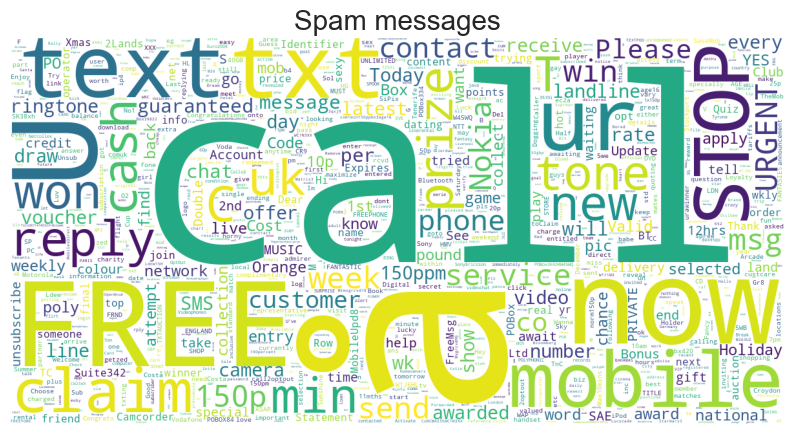

None

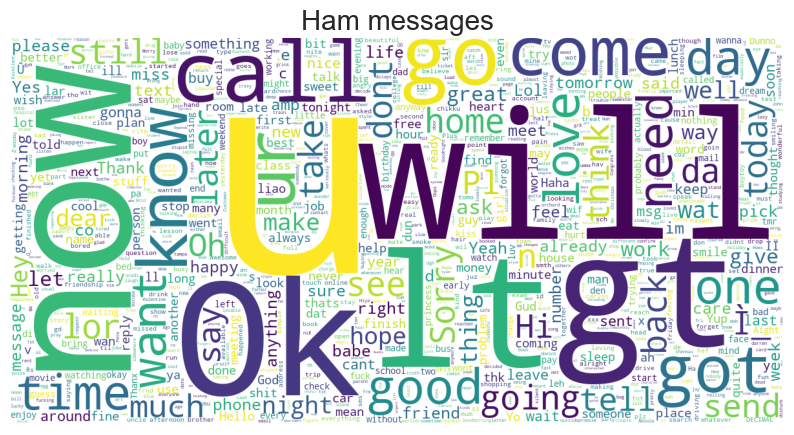

None

In [17]:
import wordcloud
ham_data = data[data['Label'] == 0].copy()
spam_data = data[data['Label'] == 1].copy()

def word_cloud(data, title):
    text = ' '.join(data['Message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    wc = wordcloud.WordCloud(stopwords=stopwords, background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1).generate(text)
    plt.figure(figsize = (10,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

display(word_cloud(spam_data, 'Spam messages'))
display(word_cloud(ham_data, 'Ham messages'))

### **4. Data Pre-processing**

The next step regarding data cleaning process would be crucial when it comes to NLP, this is necessary to make the data easier for the model to classify as well as reducing the dimensionality of the data. It is needed to convert data to something that the computer can understand.
<br> 
The steps involved in preprocessing data for Natural Language Processing are the following:
1. Cleaning messages
2. Tokenization
3. Removing stopwords 
4. Stemming/Lemmatization

#### **4.1 Cleaning Messages**

In the first step, a function needs to be created to split the message into individual words while only extracting alphabet characters and removing punctuations and numeric characters. All of this can be done with the NLTK library, a standard library for processing texts. 
<br> 
After creating the function that will process the string (messages), we will use apply() in pandas to process all the text in the dataframe. 

In [18]:
# nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

In [19]:
# 5 Sample of unclean messages 
print("\033[1m\u001b[0;1m 5 samples of unclean messages:\033[0m",*data["Message"][:5], sep = "\n")
display(data.head())

 5 samples of unclean messages:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


,Label,Message,Char_No,Words_No,Sentences_No
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
# Function for processing the messages
def clean_msg(message):
    msg = re.sub('[^a-zA-Z]', ' ', message) # replaces all non-alphanumeric characters with a blank space
    msg = msg.lower() # converts to lower case
    msg = msg.split() 
    msg = ' '.join(msg)
    return msg
data['Clean_Message'] = data['Message'].apply(clean_msg)

# Take samples of messages after cleaning
print("\033[1m\u001b[0;1m 5 samples of unclean messages:\033[0m",*data["Clean_Message"][:5], sep = "\n")
display(data.head())

 5 samples of unclean messages:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


,Label,Message,Char_No,Words_No,Sentences_No,Clean_Message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...


#### **4.2 Tokenization**

Tokenization is a natural language process that splits paragraphs and sentences into words. It pretty much breaks down any text data into smaller units called tokens that can be more easily assigned.

In [21]:
data['Tokenized_Message'] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Message"]), axis=1)
# Take samples of messages after tokenizing
print("\033[1m\u001b[0;1m Result of tokenizing:\033[0m",*data["Tokenized_Message"][:5], sep = "\n")
display(data.head())

 Result of tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


,Label,Message,Char_No,Words_No,Sentences_No,Clean_Message,Tokenized_Message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,..."


#### **4.3 Removing Stopwords**

Stopwords are words that are commonly used in a language which have no contextual meaning in a sentence, these words occur frequently in a sentence. Though the words hold meaning in a sentence, it does not add much information to the text by itself and to the language processing in NLP. This is done for the purpose of eliminating unimportant words and avoiding repetition so that our processing will focus on the important words (information) instead.

In [22]:
# Function for removing stopwords
def remove_stopwords(message):
    StopWords = set(stopwords.words("english"))
    # Check characters to see if there are punctuations 
    no_punc = [char for char in message if char not in string.punctuation]
    # now form the sentence
    no_punc = ' '.join(no_punc)
    # Eliminate any stopwords
    return [word for word in no_punc.split() if word.lower() not in StopWords]

data['No_Stopword'] = data['Tokenized_Message'].apply(remove_stopwords)
print("\033[1m\u001b[0;1m Result of removing stopwords:\033[0m",*data["No_Stopword"][:5], sep = "\n")
display(data.head())

 Result of removing stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


,Label,Message,Char_No,Words_No,Sentences_No,Clean_Message,Tokenized_Message,No_Stopword
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"


#### **4.4 Stemming/Lemmatization**

The goal of Stemming and Lemmatization is to normalize the text and prepare words/documents for the processing to be accurate when it comes to implementing the machine learning model. Both of them are used to help map multiple words to a common root word (reduces words to a common word root), the words are treated similarly and then the model is able to learn that they can be used on the same note.
<br>
<br>
**Stemming** is the approach of producing the root/base form of a word. In other words, it reduces a base word down to its stem word. It helps shorten the look-up and normalizes the sentences for better understanding. The stem of a word is obtained by removing the prefix or suffix of a word. When it comes to words, there are different forms of it; for example, the words "reached", "reaching", and "reaches", all result in their common word stem "reach" which can be used as a synonym for all three words. In this way, the NLP model can learn that all three words are similar and can be used in the same context.
<br>
<br>
**Lemmatization** converts the word to its root form but the difference is that lemmatization ensures that the root words have meaning. In other words, this process considers that there is context when the word is converted to its meaningful base form which is called Lemma. The approach entails vocabulary and morphological analysis of words, then assembling the inflected parts of a word in a way that it can be the base and dictionary form of a word. 

In [23]:
lemmatizer = WordNetLemmatizer()
# Function to lemmatize string
def lemmatize_word(message):
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in message]
    return lemmas

data['Lemmatized_Message'] = data['No_Stopword'].apply(lemmatize_word)
# Take samples of messages after lemmatizing
print("\033[1m\u001b[0;1m Result of lemmatizing:\033[0m",*data["Lemmatized_Message"][:5], sep = "\n")
display(data.head())

 Result of lemmatizing:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


,Label,Message,Char_No,Words_No,Sentences_No,Clean_Message,Tokenized_Message,No_Stopword,Lemmatized_Message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


#### **4.5 Vectorization**

Now that we have the messages that are listed as tokens (also known as lemmas), we need to convert each of these tokens into a vector so that our machine learning models can work with it smoothly. To explain more about vectorization, TF-IDF needs to be introduced. In Natural Language Processing, TF-IDF or Term Frequency-Inverse Document Frequency allows us to distinguish which words are important or not depending on how frequently it occurs in a document and corpus. Cleaned messages/data needs to be converted into a numerical format so that each word is represented by a matrix known as word vectorization. The value of TF-IDF increases proportionally to the number of times a word occurs in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [24]:
# Get every words from the dataset and append to 'corpus' that are text features to encode further into vectorized form
corpus = []
for i in data['Lemmatized_Message']:
    message = ' '.join([row for row in i])
    corpus.append(message)

# Take samples of messages after vectorization
print("\033[1m\u001b[0;1m Result of Vectorization:\033[0m",*corpus[:5], sep = "\n")

 Result of Vectorization:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


### **5. Building and Evaluation of Models**

In [25]:
# Set values for the features and labels as X and y respectively then we change text data to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
y = data["Label"]

In [26]:
cmap = ListedColormap(["#f3fabe", "#6ac5bd"])
# Function for the model building and prediction
def create_model(model, X, y):
    # Training and testing dataset by taking in X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=107)
    # Pipeline for training models
    pipeline_model = Pipeline([('classifier', model)])
    pipeline_model.fit(X_train, y_train)

    y_pred = pipeline_model.predict(X_test)
    y_prob = pipeline_model.predict_proba(X_test)

    # Plotting and printing out model results
    roc_graph = skplt.metrics.plot_roc(y_test,y_prob,figsize=(10,5),title_fontsize=12,text_fontsize=16)
    plt.show(roc_graph)
    recall_graph = skplt.metrics.plot_precision_recall(y_test,y_prob,figsize=(10,5),title_fontsize=12,text_fontsize=16)
    plt.show(recall_graph)
    conf_mat = skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(10,5),title_fontsize=12,text_fontsize=16,cmap=cmap,title=type(model).__name__)
    plt.show(conf_mat)
    
    # Display classification report including precision, recall, f1_score, and accuracies
    report = classification_report(y_test, y_pred, output_dict=True)
    dataframe_report = pd.DataFrame(report).transpose()
    display(dataframe_report)
    print('Testing Accuracy:\n', pipeline_model.score(X_test, y_test)*100)
    print("Training Accuracy:\n",pipeline_model.score(X_train,y_train)*100)

#### **5.1 Model List I** 


Model: MultinomialNB


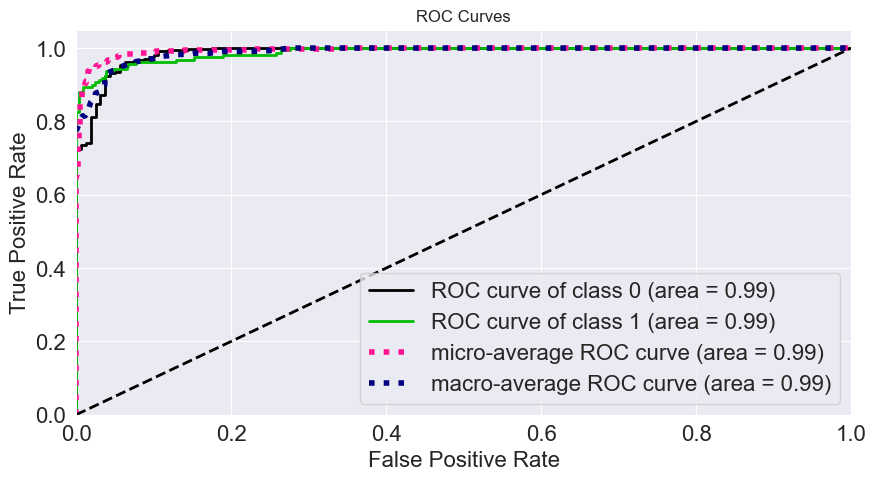

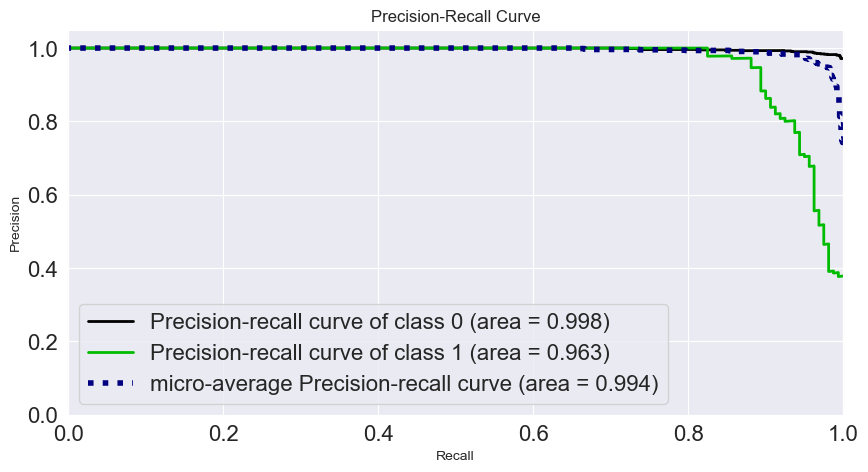

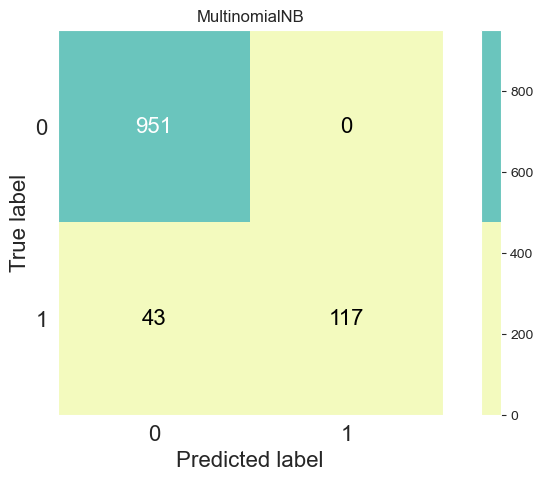

,precision,recall,f1-score,support
0,0.956740,1.000000,0.977892,951.000000
1,1.000000,0.731250,0.844765,160.000000
accuracy,0.961296,0.961296,0.961296,0.961296
macro avg,0.978370,0.865625,0.911329,1111.000000
weighted avg,0.962970,0.961296,0.958720,1111.000000


Testing Accuracy:
 96.12961296129613
Training Accuracy:
 97.54725472547254

Model: RandomForestClassifier


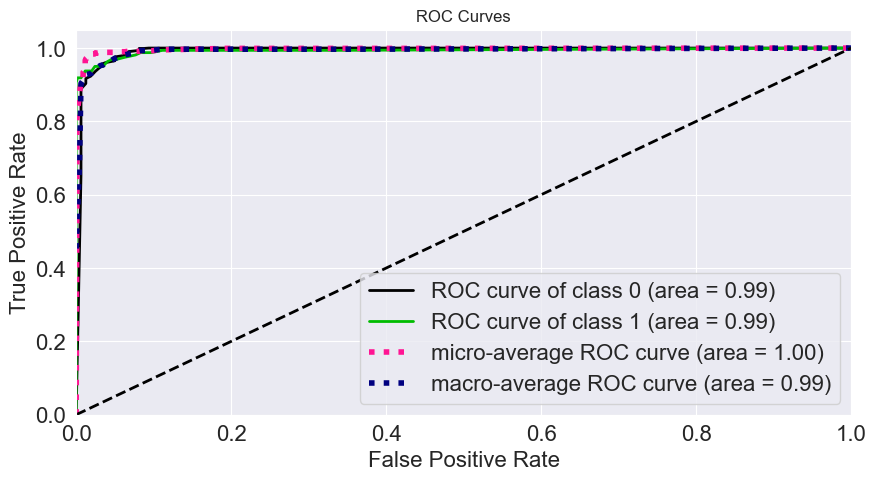

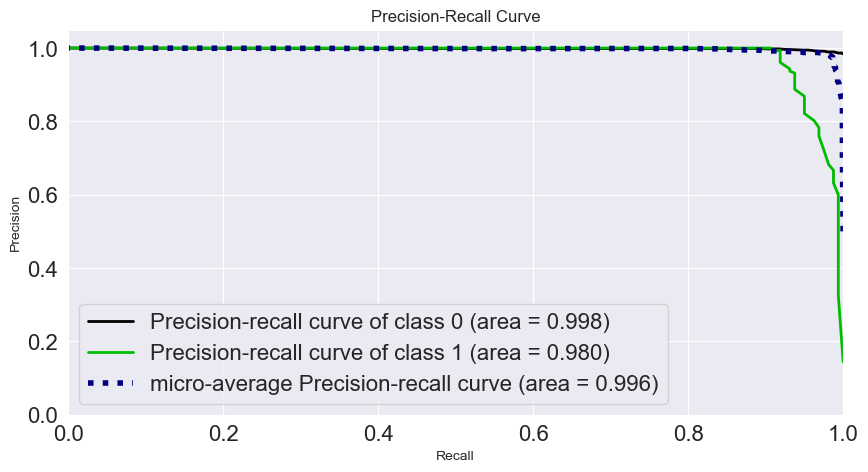

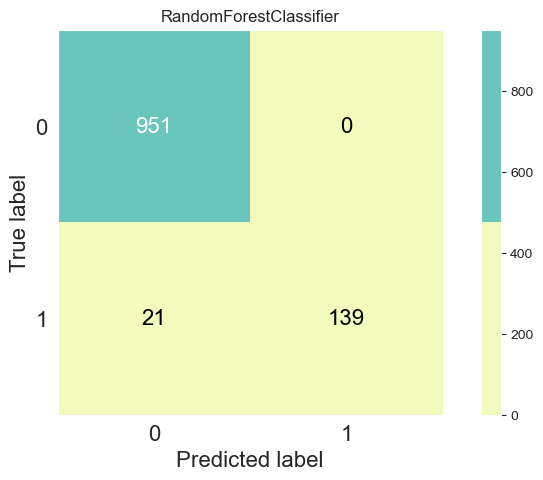

,precision,recall,f1-score,support
0,0.978395,1.000000,0.989080,951.000000
1,1.000000,0.868750,0.929766,160.000000
accuracy,0.981098,0.981098,0.981098,0.981098
macro avg,0.989198,0.934375,0.959423,1111.000000
weighted avg,0.981506,0.981098,0.980538,1111.000000


Testing Accuracy:
 98.10981098109811
Training Accuracy:
 100.0

Model: KNeighborsClassifier


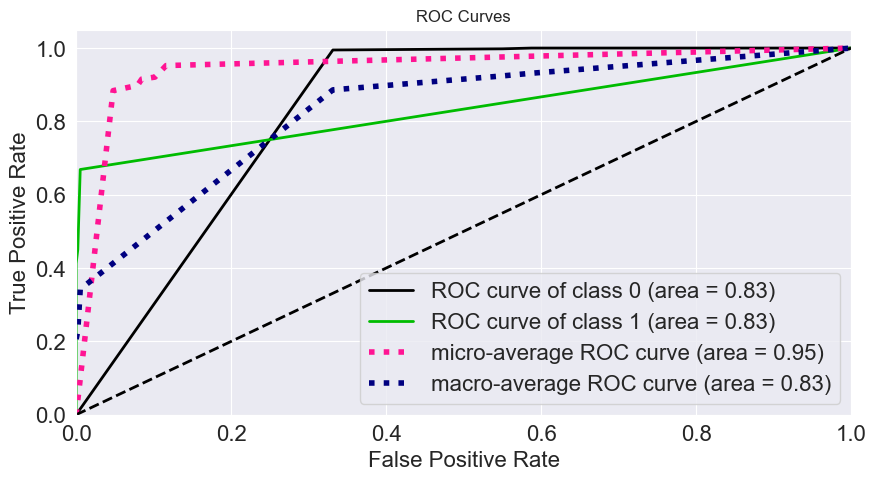

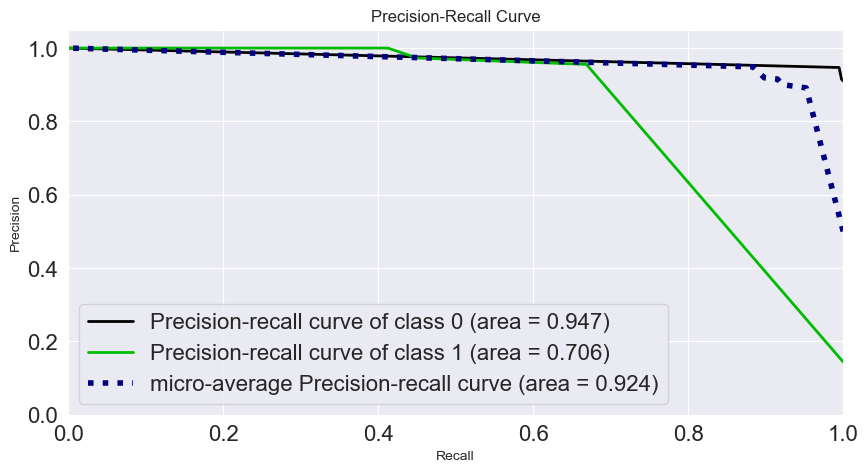

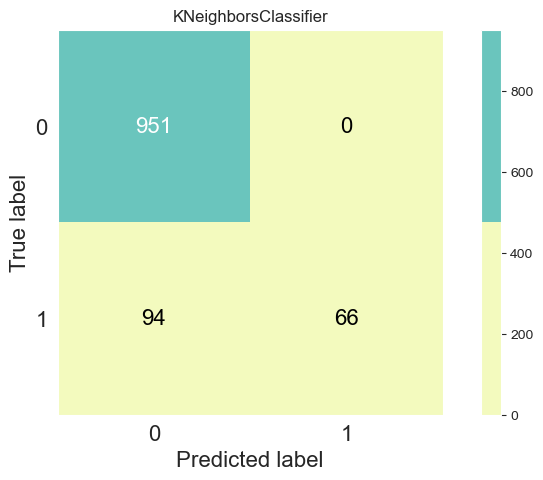

,precision,recall,f1-score,support
0,0.910048,1.000000,0.952906,951.000000
1,1.000000,0.412500,0.584071,160.000000
accuracy,0.915392,0.915392,0.915392,0.915392
macro avg,0.955024,0.706250,0.768488,1111.000000
weighted avg,0.923002,0.915392,0.899788,1111.000000


Testing Accuracy:
 91.53915391539154
Training Accuracy:
 93.06930693069307

Model: SVC


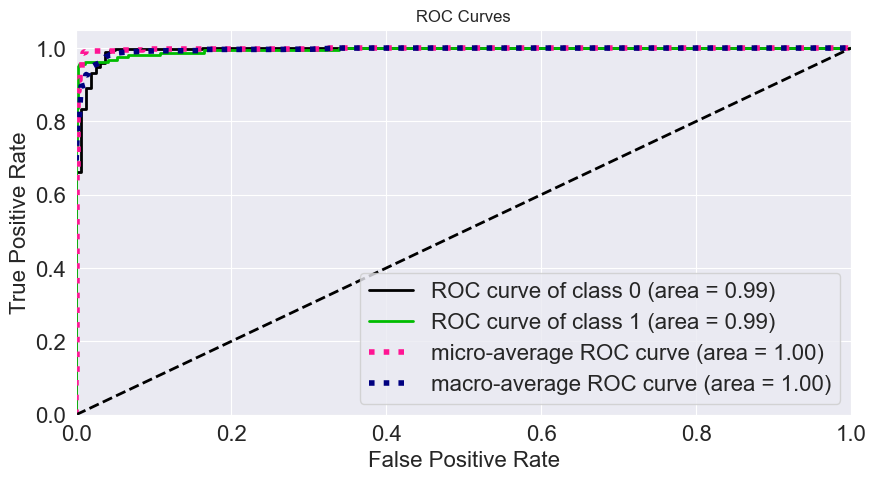

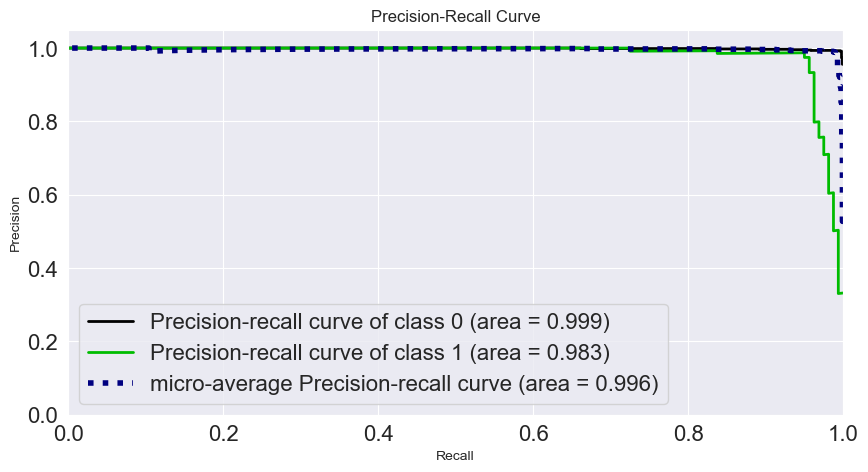

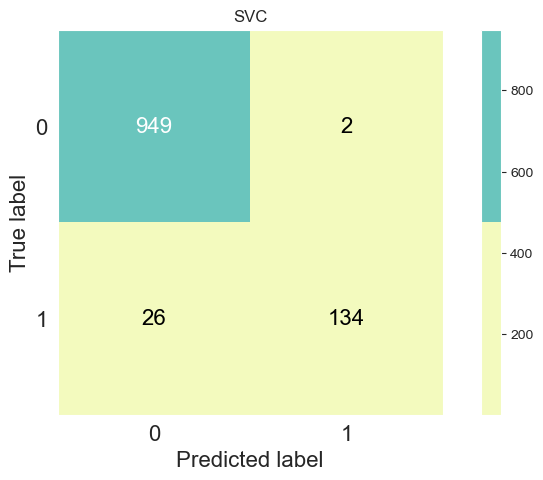

,precision,recall,f1-score,support
0,0.973333,0.997897,0.985462,951.000000
1,0.985294,0.837500,0.905405,160.000000
accuracy,0.974797,0.974797,0.974797,0.974797
macro avg,0.979314,0.917698,0.945434,1111.000000
weighted avg,0.975056,0.974797,0.973933,1111.000000


Testing Accuracy:
 97.47974797479748
Training Accuracy:
 99.79747974797479

Model: LogisticRegression


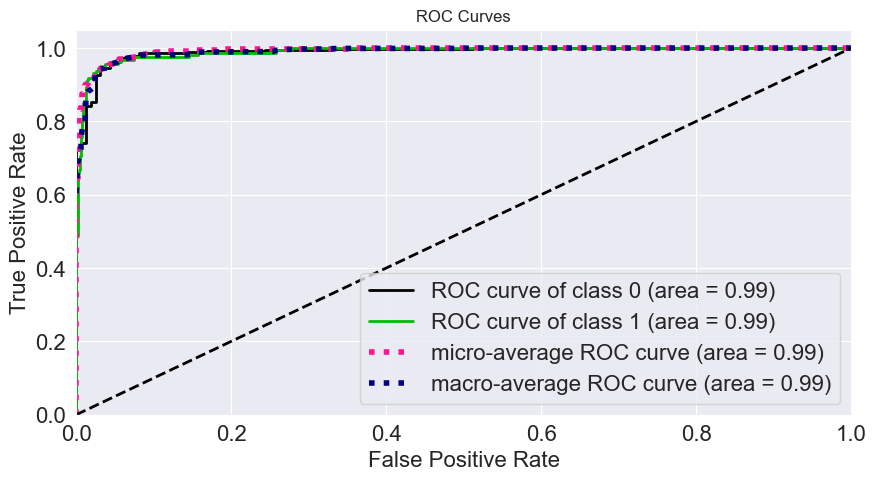

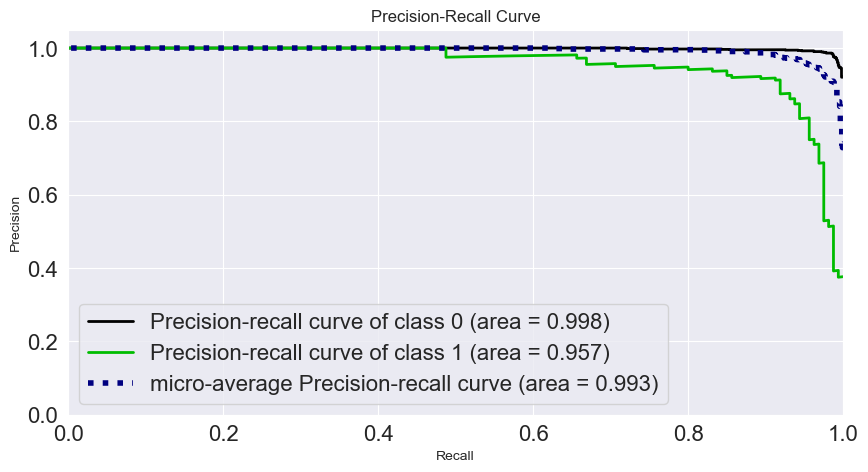

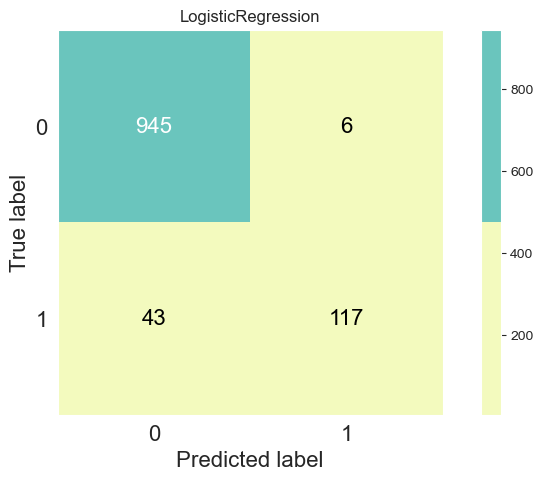

,precision,recall,f1-score,support
0,0.956478,0.993691,0.974729,951.000000
1,0.951220,0.731250,0.826855,160.000000
accuracy,0.955896,0.955896,0.955896,0.955896
macro avg,0.953849,0.862470,0.900792,1111.000000
weighted avg,0.955720,0.955896,0.953433,1111.000000


Testing Accuracy:
 95.5895589558956
Training Accuracy:
 97.14221422142214


In [27]:
# Initializing models 
mnb = MultinomialNB()
rfc = RandomForestClassifier()
knc = KNeighborsClassifier()
svc = SVC(probability=True)
lr = LogisticRegression()
classifiers = [
    mnb, 
    rfc, 
    knc, 
    svc,
    lr
]
pipeline_dict = {
    0: 'MultinomialNB',
    1: 'RandomForestClassifier',
    2: 'KNeighborsClassifier',
    3: 'SVC',
    4: 'LogisticRegression'
}

for i, model in enumerate(classifiers):
    print("\033[1m\u001b[0;1m\nModel: %s\033[0m" % (pipeline_dict[i]), end='\n')
    create_model(model, X, y)

#### **5.2 Model List II** 


Model: XGBClassifier


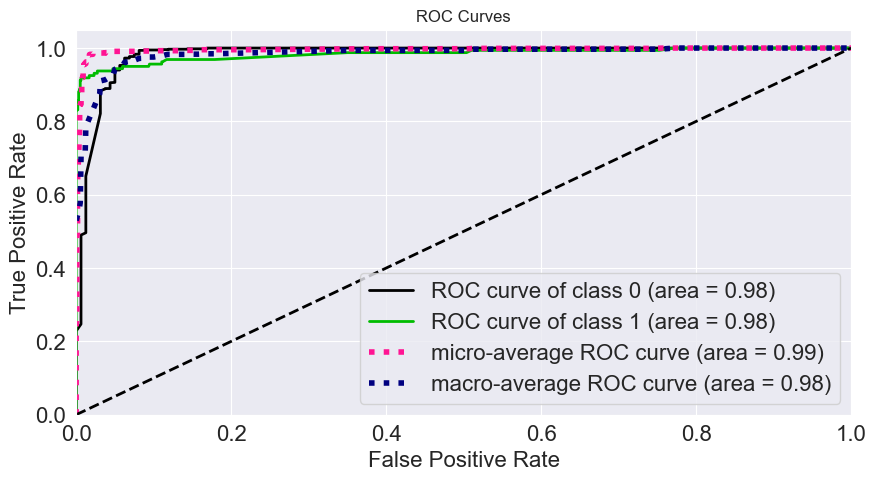

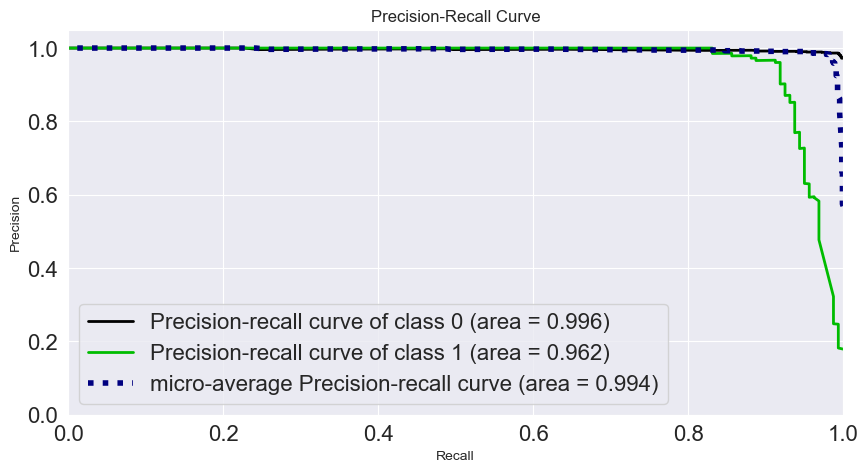

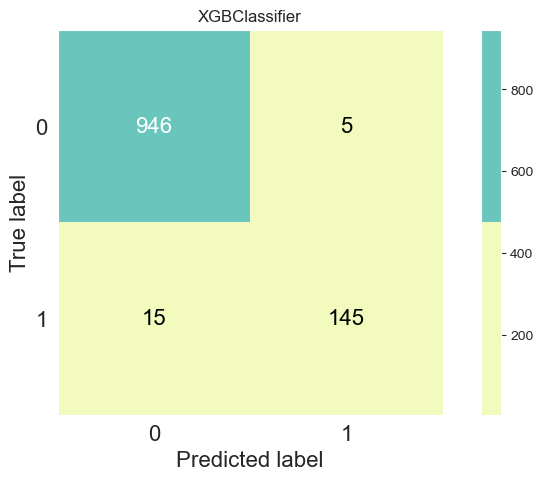

,precision,recall,f1-score,support
0,0.984391,0.994742,0.989540,951.000000
1,0.966667,0.906250,0.935484,160.000000
accuracy,0.981998,0.981998,0.981998,0.981998
macro avg,0.975529,0.950496,0.962512,1111.000000
weighted avg,0.981839,0.981998,0.981755,1111.000000


Testing Accuracy:
 98.1998199819982
Training Accuracy:
 99.21242124212422

Model: DecisionTreeClassifier


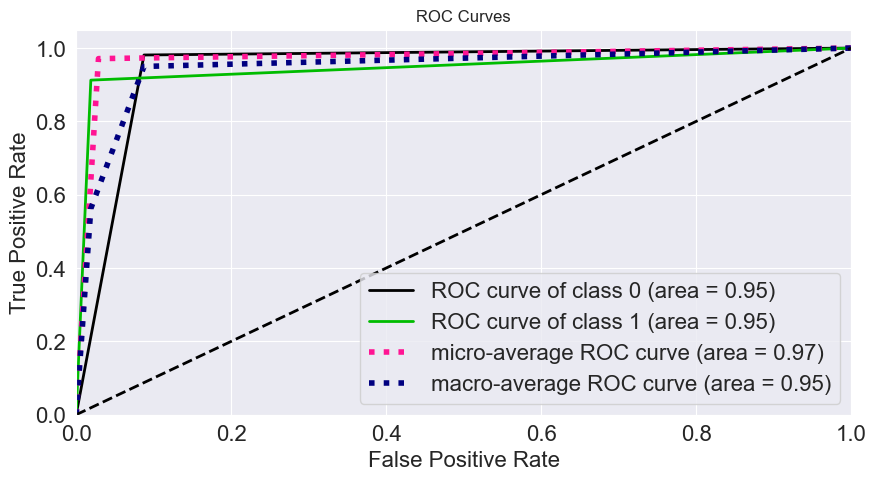

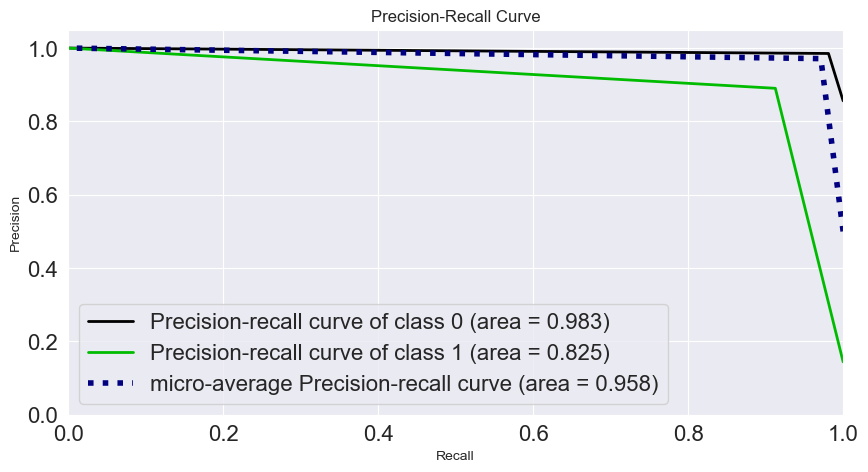

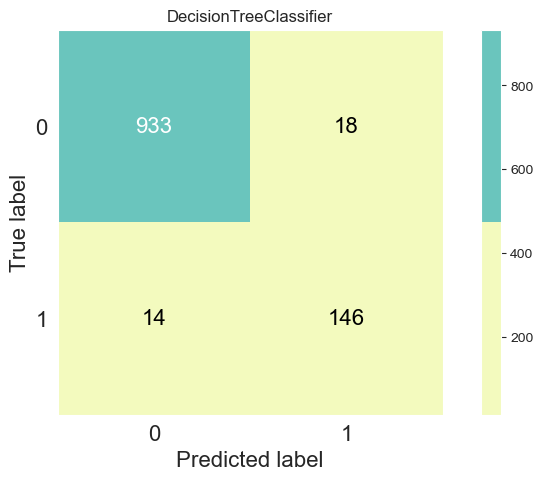

,precision,recall,f1-score,support
0,0.985216,0.981073,0.983140,951.000000
1,0.890244,0.912500,0.901235,160.000000
accuracy,0.971197,0.971197,0.971197,0.971197
macro avg,0.937730,0.946786,0.942187,1111.000000
weighted avg,0.971539,0.971197,0.971345,1111.000000


Testing Accuracy:
 97.11971197119712
Training Accuracy:
 100.0

Model: AdaBoostClassifier


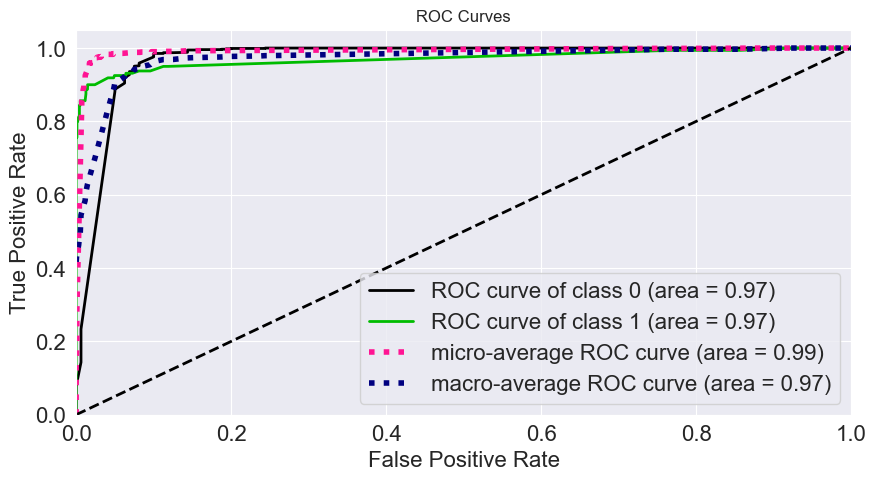

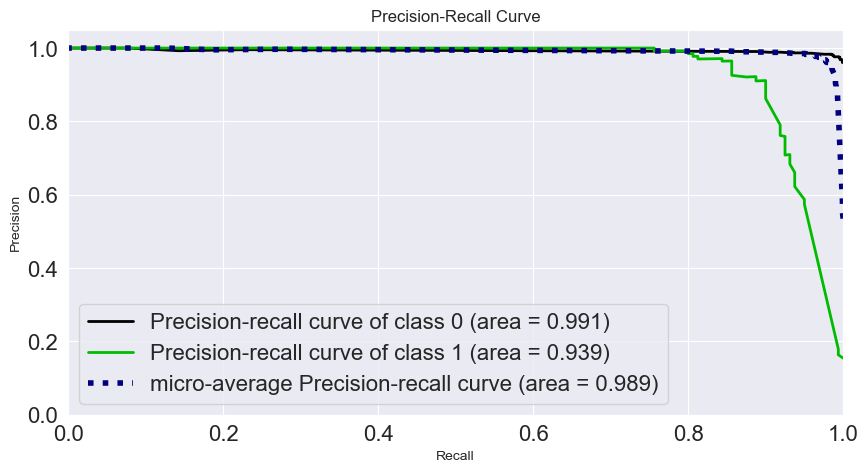

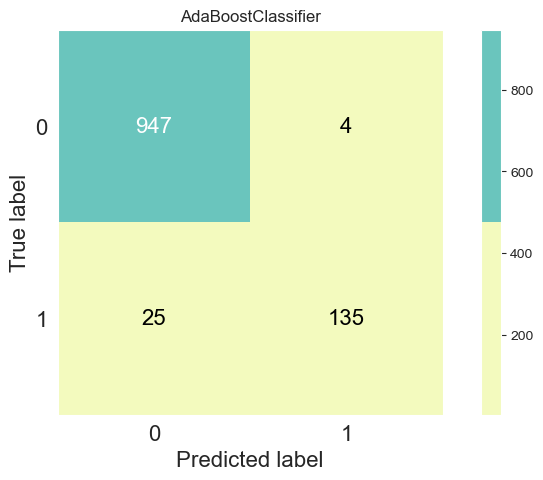

,precision,recall,f1-score,support
0,0.974280,0.995794,0.984919,951.000000
1,0.971223,0.843750,0.903010,160.000000
accuracy,0.973897,0.973897,0.973897,0.973897
macro avg,0.972751,0.919772,0.943965,1111.000000
weighted avg,0.973840,0.973897,0.973123,1111.000000


Testing Accuracy:
 97.3897389738974
Training Accuracy:
 98.04230423042304

Model: ExtraTreesClassifier


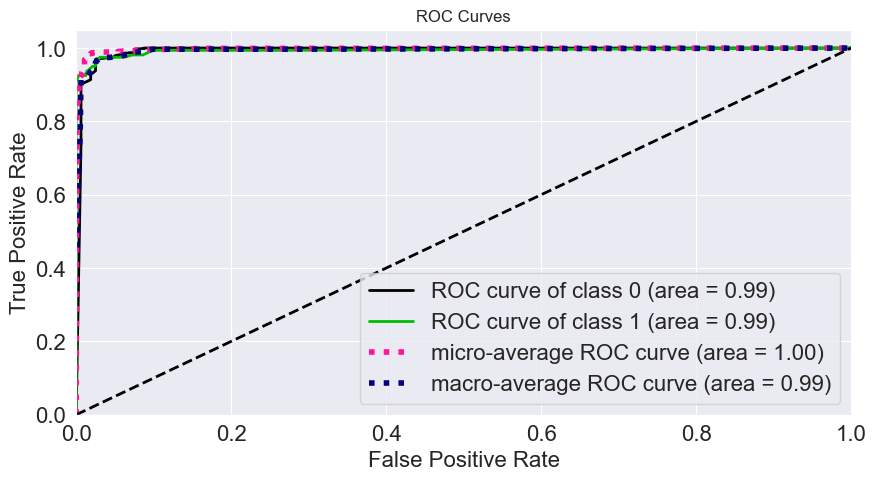

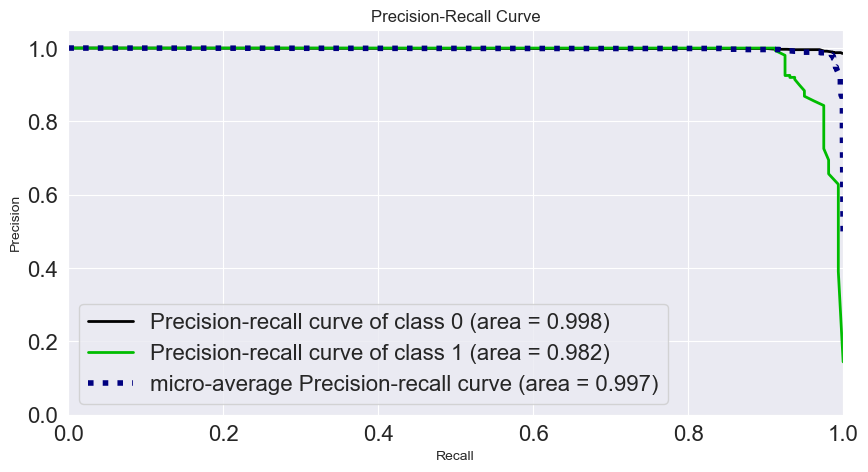

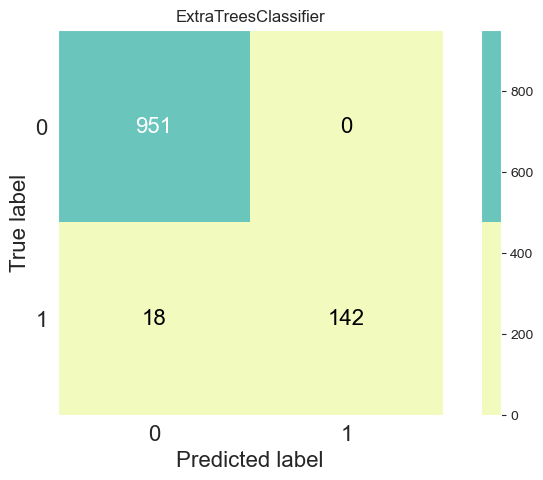

,precision,recall,f1-score,support
0,0.981424,1.000000,0.990625,951.000000
1,1.000000,0.887500,0.940397,160.000000
accuracy,0.983798,0.983798,0.983798,0.983798
macro avg,0.990712,0.943750,0.965511,1111.000000
weighted avg,0.984099,0.983798,0.983391,1111.000000


Testing Accuracy:
 98.37983798379838
Training Accuracy:
 100.0

Model: GradientBoostingClassifier


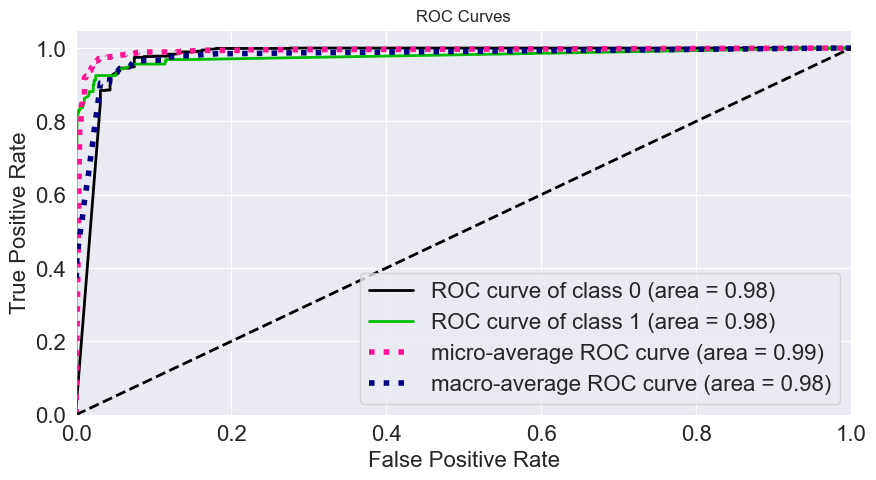

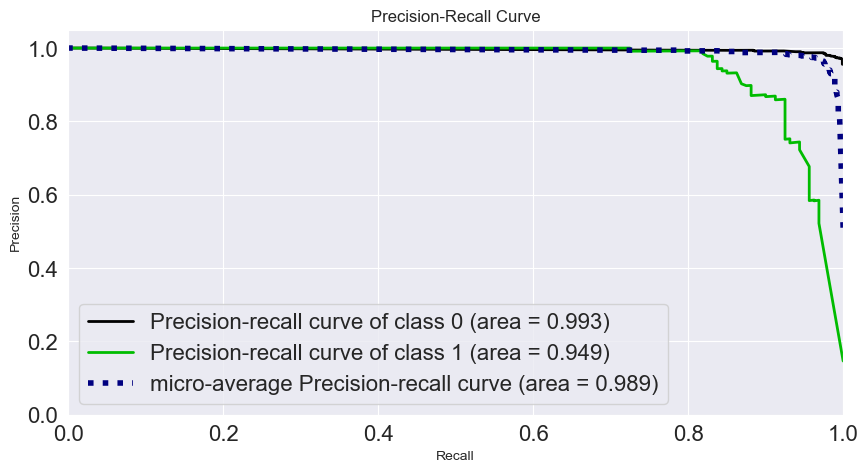

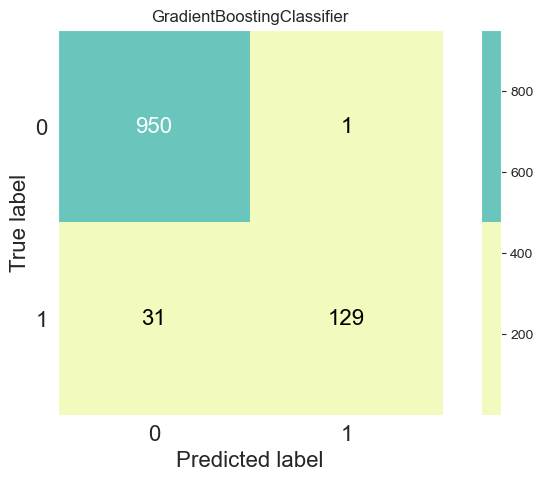

,precision,recall,f1-score,support
0,0.968400,0.998948,0.983437,951.000000
1,0.992308,0.806250,0.889655,160.000000
accuracy,0.971197,0.971197,0.971197,0.971197
macro avg,0.980354,0.902599,0.936546,1111.000000
weighted avg,0.971843,0.971197,0.969931,1111.000000


Testing Accuracy:
 97.11971197119712
Training Accuracy:
 98.44734473447345


In [28]:
# Initializing models 
xgb = XGBClassifier()
dtc = tree.DecisionTreeClassifier()
adb = AdaBoostClassifier()
etc = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()
classifiers2 = [
    xgb,
    dtc,
    adb,
    etc,
    gbc
]
pipeline_dict2 = {
    0: 'XGBClassifier',
    1: 'DecisionTreeClassifier',
    2: 'AdaBoostClassifier',
    3: 'ExtraTreesClassifier',
    4: 'GradientBoostingClassifier'
}

for i, model in enumerate(classifiers2):
    print("\033[1m\u001b[0;1m\nModel: %s\033[0m" % (pipeline_dict2[i]), end='\n')
    create_model(model, X, y)

### **6. Saving the Models**

In [29]:
# Save the model to be used for predicting later on
pickle.dump(tfidf, open(r'../SMS_spam_detection/Models/vectorizer.pkl', 'wb'))
pickle.dump(etc, open(r'../SMS_spam_detection/Models/model.pkl', 'wb'))

### **7. Conclusion**

From the models used previously, it can be observed that Random forest and SVC are the models with the highest accuracy in the first list of models whereas in the second list of models, almost all of them have high accuracy but XGB and Extra Trees Classifiers seems to be top in all of them. In that case, we'll just pick the Extra Trees Classifier model and then save it to be used for spam prediction for the website. 